Logistic Regression Results
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.92      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.94      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

ROC-AUC: 0.9873744105635812

Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19968
           1       0.22      0.72      0.33        32

    accuracy                           1.00     20000
   macro avg       0.61      0.86      0.67     20000
weighted avg       1.00      1.00      1.00     20000

ROC-AUC: 0.9905653733473557


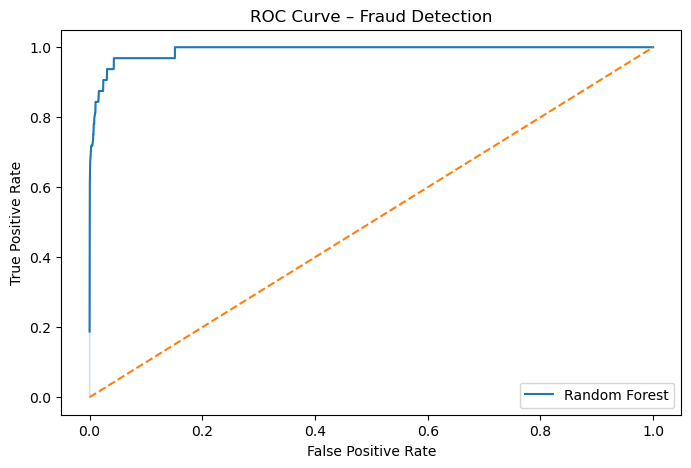

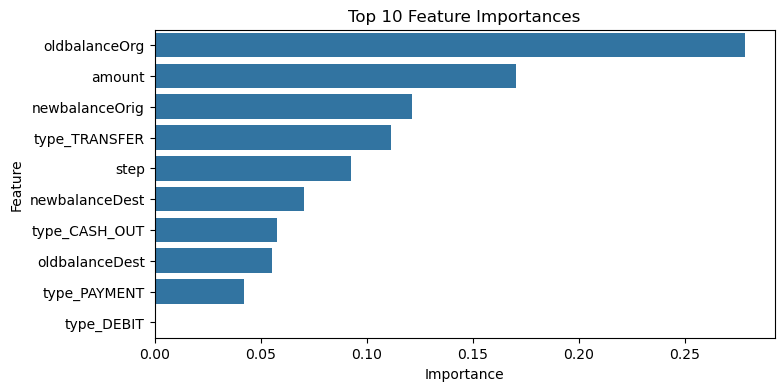

In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve
)
#load data
df = pd.read_csv("Transactions Data.csv")

#Preprocessing
# Drop identifiers & leakage
df.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], inplace=True)

# Encode categorical column
df = pd.get_dummies(df, columns=["type"], drop_first=True)

# Features & target
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
#Logistic Regression (Baseline)
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# Random Forest (Sampled)
# Sample for efficiency
X_rf_sample = X_train.sample(100000, random_state=42)
y_rf_sample = y_train.loc[X_rf_sample.index]

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_rf_sample, y_rf_sample)

# Test subset
X_test_rf = X_test[:20000]
y_test_rf = y_test[:20000]

y_pred_rf = rf.predict(X_test_rf)
y_prob_rf = rf.predict_proba(X_test_rf)[:, 1]

print("\nRandom Forest Results")
print(classification_report(y_test_rf, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test_rf, y_prob_rf))

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
plt.figure(figsize=(8,5))
sns.lineplot(x=fpr, y=tpr, label="Random Forest")
sns.lineplot(x=[0,1], y=[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Fraud Detection")
plt.legend()
plt.show()

# 7. Feature Importance
importances = pd.Series(
    rf.feature_importances_,
    index=X_rf_sample.columns
).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [2]:
X_rf = X_train.sample(500000, random_state=42)
y_rf = y_train.loc[X_rf.index]

import xgboost as xgb

scale_pos_weight = (y_rf == 0).sum() / (y_rf == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_rf, y_rf)

y_pred_xgb = xgb_model.predict(X_test[:200000])
y_prob_xgb = xgb_model.predict_proba(X_test[:200000])[:, 1]

print(classification_report(y_test[:200000], y_pred_xgb))
print("ROC-AUC (XGB):", roc_auc_score(y_test[:200000], y_prob_xgb))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199731
           1       0.18      0.99      0.30       269

    accuracy                           0.99    200000
   macro avg       0.59      0.99      0.65    200000
weighted avg       1.00      0.99      1.00    200000

ROC-AUC (XGB): 0.9996300042144044


In [3]:
import numpy as np
from sklearn.metrics import classification_report

thresholds = [0.1, 0.2, 0.3, 0.5]

for t in thresholds:
    print(f"\nThreshold = {t}")
    y_pred_t = (y_prob_rf >= t).astype(int)
    print(classification_report(y_test_rf, y_pred_t))


Threshold = 0.1
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     19968
           1       0.03      0.97      0.06        32

    accuracy                           0.96     20000
   macro avg       0.52      0.96      0.52     20000
weighted avg       1.00      0.96      0.98     20000


Threshold = 0.2
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19968
           1       0.06      0.88      0.11        32

    accuracy                           0.98     20000
   macro avg       0.53      0.93      0.55     20000
weighted avg       1.00      0.98      0.99     20000


Threshold = 0.3
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     19968
           1       0.08      0.84      0.15        32

    accuracy                           0.98     20000
   macro avg       0.54      0.91      0.57     20000
weighted avg       1.00

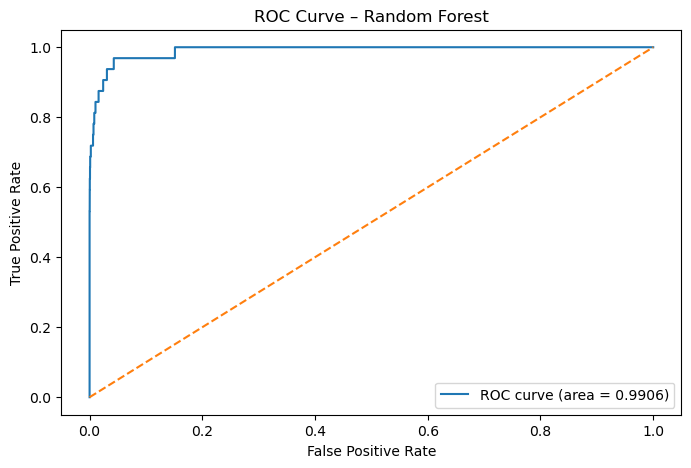

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_rf, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()


Top 10 Important Features:
oldbalanceOrg     0.278398
amount            0.170382
newbalanceOrig    0.121508
type_TRANSFER     0.111529
step              0.092624
newbalanceDest    0.070444
type_CASH_OUT     0.057808
oldbalanceDest    0.055337
type_PAYMENT      0.041968
type_DEBIT        0.000003
dtype: float64


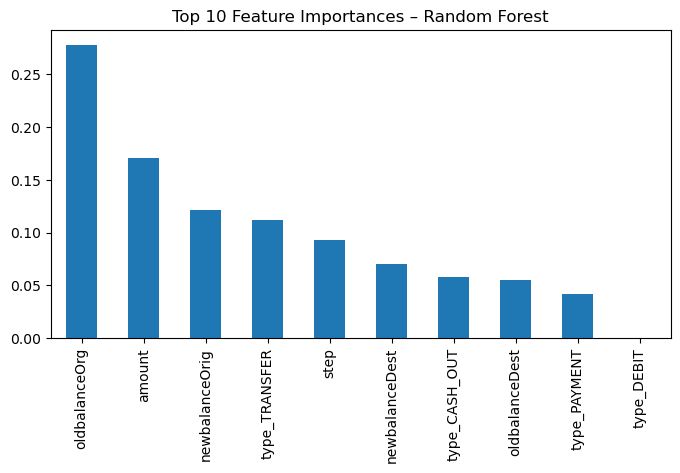

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(
    rf.feature_importances_,
    index=X_rf_sample.columns
).sort_values(ascending=False)

print("Top 10 Important Features:")
print(importances.head(10))

importances.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Feature Importances – Random Forest")
plt.show()


In [6]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
#Logistic Regression
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test[:200000])
y_prob_lr = lr.predict_proba(X_test[:200000])[:, 1]

print("\n===== Logistic Regression =====")
print(classification_report(y_test[:200000], y_pred_lr))
print("ROC-AUC (LR):", roc_auc_score(y_test[:200000], y_prob_lr))

#Random Forest

X_rf = X_train.sample(300000, random_state=42)
y_rf = y_train.loc[X_rf.index]

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=8,
    class_weight='balanced',
    random_state=42,
)

rf.fit(X_rf, y_rf)

y_pred_rf = rf.predict(X_test[:200000])
y_prob_rf = rf.predict_proba(X_test[:200000])[:, 1]

print("\n===== Random Forest =====")
print(classification_report(y_test[:200000], y_pred_rf))
print("ROC-AUC (RF):", roc_auc_score(y_test[:200000], y_prob_rf))

# XGBoost (sampled)
X_xgb = X_train.sample(500000, random_state=42)
y_xgb = y_train.loc[X_xgb.index]

scale_pos_weight = (y_xgb == 0).sum() / (y_xgb == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_xgb, y_xgb)
y_pred_xgb = xgb_model.predict(X_test[:200000])
y_prob_xgb = xgb_model.predict_proba(X_test[:200000])[:, 1]

print("\n===== XGBoost =====")
print(classification_report(y_test[:200000], y_pred_xgb))
print("ROC-AUC (XGB):", roc_auc_score(y_test[:200000], y_prob_xgb))





===== Logistic Regression =====
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    199731
           1       0.03      0.93      0.06       269

    accuracy                           0.96    200000
   macro avg       0.52      0.95      0.52    200000
weighted avg       1.00      0.96      0.98    200000

ROC-AUC (LR): 0.9857357216087609

===== Random Forest =====
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    199731
           1       0.11      0.93      0.20       269

    accuracy                           0.99    200000
   macro avg       0.56      0.96      0.60    200000
weighted avg       1.00      0.99      0.99    200000

ROC-AUC (RF): 0.997863753142028

===== XGBoost =====
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199731
           1       0.18      0.99      0.30       269

    accuracy                        

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Base weak learner
base_estimator = DecisionTreeClassifier(
    max_depth=2,
    class_weight='balanced',
    random_state=42
)

# AdaBoost model
ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=50,
    learning_rate=0.5,
    random_state=42
)

# Train AdaBoost
print("Training AdaBoost...")
ada.fit(X_train, y_train)
print("Training completed")

# Predict on same test subset
y_pred_ada = ada.predict(X_test[:200000])
y_prob_ada = ada.predict_proba(X_test[:200000])[:, 1]

# Evaluation
print("\n===== AdaBoost =====")
print(classification_report(y_test[:200000], y_pred_ada))
print("ROC-AUC (AdaBoost):", roc_auc_score(y_test[:200000], y_prob_ada))

Training AdaBoost...
Training completed

===== AdaBoost =====
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199731
           1       0.13      0.77      0.23       269

    accuracy                           0.99    200000
   macro avg       0.57      0.88      0.61    200000
weighted avg       1.00      0.99      1.00    200000

ROC-AUC (AdaBoost): 0.989323232684764


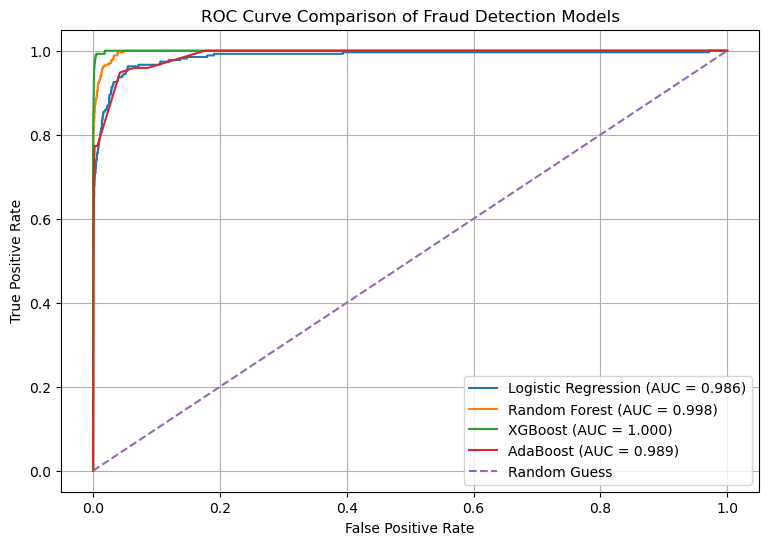

In [11]:
# compare all 4 models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Same true labels for all models
y_true = y_test[:200000]

# ROC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_true, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_true, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# ROC for AdaBoost
fpr_ada, tpr_ada, _ = roc_curve(y_true, y_prob_ada)
auc_ada = auc(fpr_ada, tpr_ada)

# Plot all ROC curves
plt.figure(figsize=(9, 6))

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC = {auc_ada:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Fraud Detection Models")
plt.legend()
plt.grid(True)
plt.show()